In [8]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import mglearn
import os

# パイプラインとグリッドサーチでパラメータの検討から学習まで一気に実装  

* まずはこれまでの何でもない書き方  

In [4]:
from sklearn.datasets import load_breast_cancer
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import roc_auc_score

cancer = load_breast_cancer()
X_train, X_test, y_train, y_test = train_test_split(
    cancer.data,cancer.target,random_state=0
)
scaler = MinMaxScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

svc = SVC().fit(X_train_scaled,y_train)
print(f'accuracy on test  : {svc.score(X_test_scaled,y_test):.3f}')
print(f'auc score on test : {roc_auc_score(y_test,svc.predict(X_test_scaled)):.3f}')

accuracy on test  : 0.972
auc score on test : 0.966


* グリッドサーチでパラメータを検討すると・・・

In [7]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'C':[.001, .01, .1, 1, 10, 100],
    'gamma':[.001, .01, .1, 1, 10, 100]
}

grid = GridSearchCV(estimator=SVC(),param_grid=param_grid,cv=5)
grid.fit(X_train_scaled,y_train)
print(f'best_params   : {grid.best_params_}')
print(f'best_score    : {grid.best_score_:.3f}')
print(f'test accuracy : {grid.score(X_test_scaled,y_test):.3f}')
print(f'test auc      : {roc_auc_score(y_test,grid.predict(X_test_scaled)):.3f}')

best_params   : {'C': 1, 'gamma': 1}
best_score    : 0.981
test accuracy : 0.972
test auc      : 0.966


* ↑はだめ！  
特徴量のスケーリングは訓練データのみを使って学習しないといけない。  
グリッドサーチでは訓練データから検証データを切り出して学習-検証を繰り返すが、その前に訓練データ全体で学習したスケーラーを使っているので汎化できていない！

* 本来は、交差検証時は真の訓練データで学習したスケーラーを使い、テストデータの評価時は訓練データ全体で学習したスケーラーを使うべき

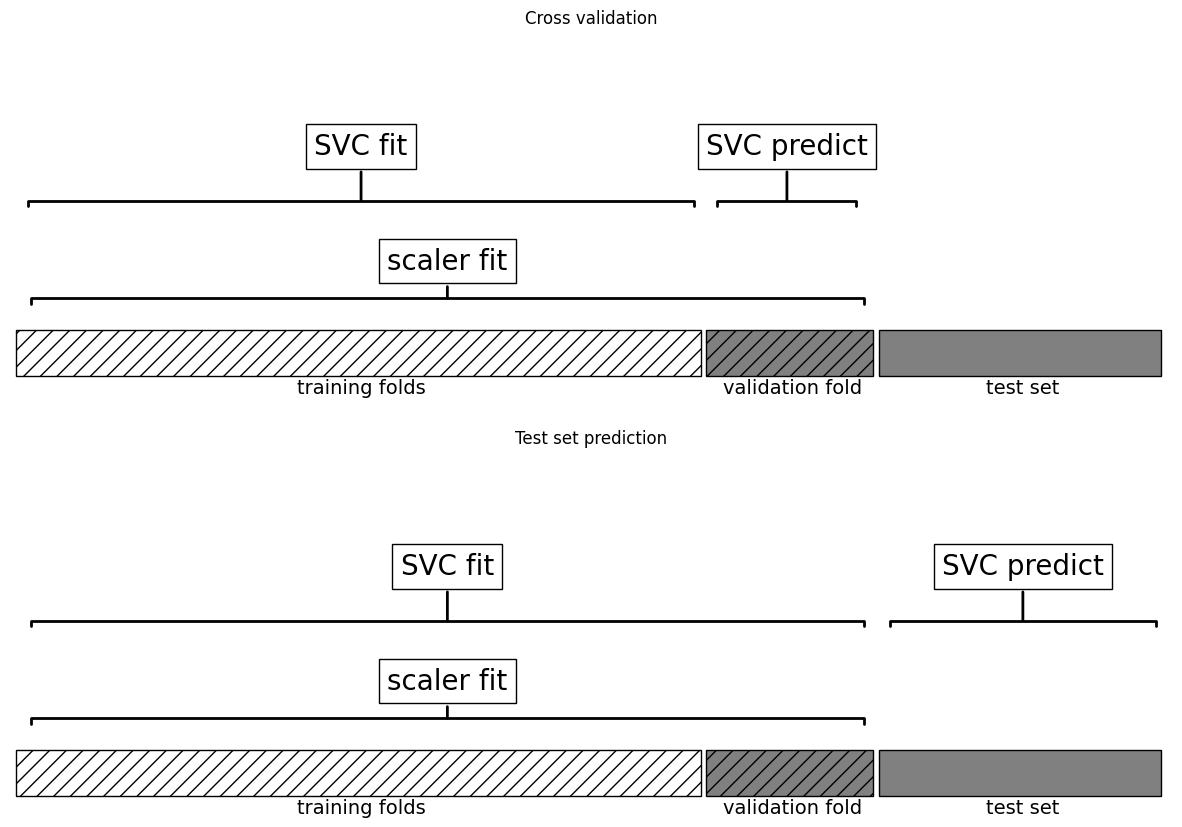

In [10]:
mglearn.plots.plot_improper_processing()
# 適切な方法

* Pipelineを使ってみる  
`Pipeline()`の引数は`('Estimater_name',Estimater)`のリスト。  
リストのインデックスの順番に与えられたデータを実行する一塊のEstimaterとして機能する。  
以下の例であれば、`pipe.fit(X_train,y_train)`をすることで  
1. `('scaler',MinMaxScaler())` : `MinMaxscaler.fit(X_train)`をまず実行
1. `('svm',SVC())`             : `SVC.fit(MinMaxscaler.fit(X_train).transform(X_train),y_train)`を次に実行

In [11]:
from sklearn.pipeline import Pipeline
pipe = Pipeline([
        ('scaler',MinMaxScaler()),
        ('svm',SVC())
    ])

In [13]:
pipe.fit(X_train,y_train)
print(f'score : {pipe.score(X_test,y_test):.3f}')

score : 0.972


* このpipeを使ってグリッドサーチとか交差検証が可能

In [16]:
param_grid = {
    'svm__C':[.001, .01, .1, 1, 10, 100],
    'svm__gamma':[.001, .01, .1, 1, 10, 100]
}
grid = GridSearchCV(estimator=pipe,param_grid=param_grid,cv=5).fit(X_train,y_train)
print(f'best_params   : {grid.best_params_}')
print(f'best_score    : {grid.best_score_:.3f}')
print(f'test accuracy : {grid.score(X_test,y_test):.3f}')
print(f'test auc      : {roc_auc_score(y_test,grid.predict(X_test)):.3f}')

best_params   : {'svm__C': 1, 'svm__gamma': 1}
best_score    : 0.981
test accuracy : 0.972
test auc      : 0.966


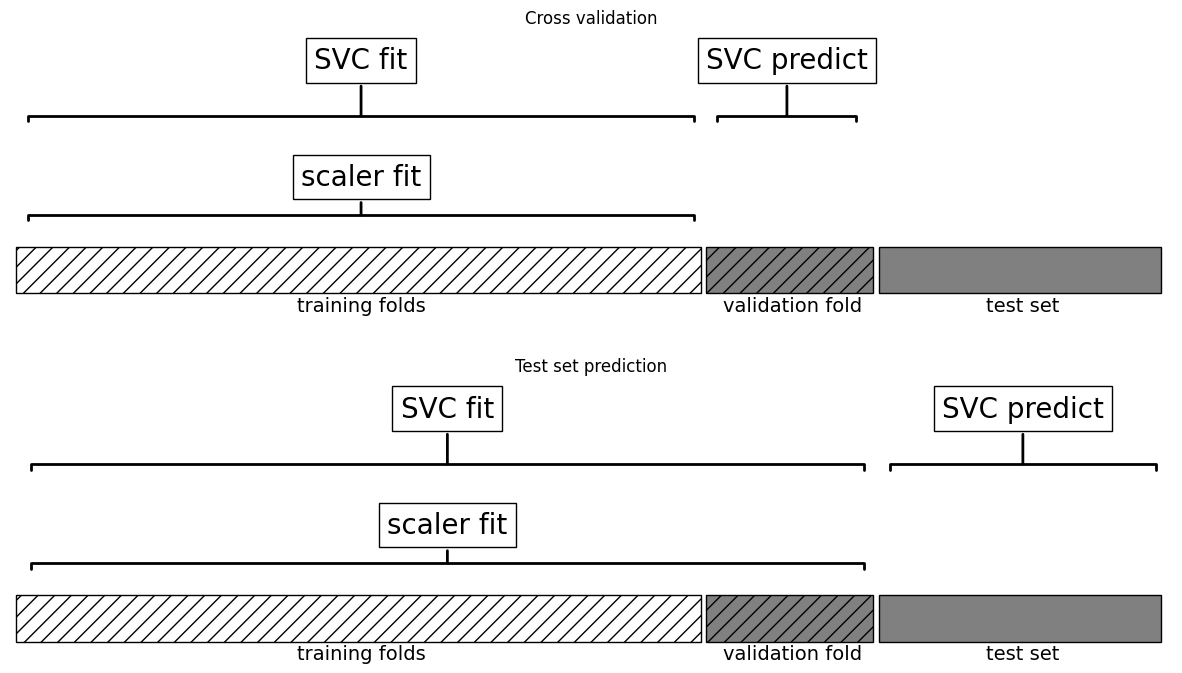

In [17]:
mglearn.plots.plot_proper_processing()

In [18]:
from sklearn.pipeline import make_pipeline
# 各ステップの命名を省略できる
pipe_short = make_pipeline(MinMaxScaler(),SVC())
pipe_short.steps

[('minmaxscaler', MinMaxScaler()), ('svc', SVC())]

`make_pipeline()`で指定するとモデル名の小文字が自動的に名前として付与

In [19]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

pipe_short_2 = make_pipeline(StandardScaler(),PCA(n_components=2),StandardScaler())
pipe_short_2.steps

[('standardscaler-1', StandardScaler()),
 ('pca', PCA(n_components=2)),
 ('standardscaler-2', StandardScaler())]

In [25]:
pipe_short_2.steps[1][0]

'pca'

同じモデルが複数登場する場合は`modelname-n`

* pipelineの中の属性を取り出したいときは、`named_steps`を使う。  
これは`{'step_name':estimator}`の辞書

In [23]:
pipe_short_2.fit(X_train,y_train)
components = pipe_short_2.named_steps['pca'].components_
components.shape

(2, 30)

* グリッドサーチの内部を取り出す場合

In [28]:
from sklearn.linear_model import LogisticRegression
pipe = make_pipeline(StandardScaler(),LogisticRegression(max_iter=2000))
param_grid = {
    f'{pipe.steps[1][0]}__C':[.01, .1, 1, 10, 100]
}

grid = GridSearchCV(estimator=pipe,param_grid=param_grid,cv=5)
grid.fit(X_train,y_train)
print(f'best_param : {grid.best_params_}')
print(f'best_score : {grid.best_score_:.3f}')
print(f'test accuracy : {grid.score(X_test,y_test):.3f}')

best_param : {'logisticregression__C': 1}
best_score : 0.981
test accuracy : 0.958


In [33]:
grid.best_estimator_.named_steps[pipe.steps[1][0]].coef_

array([[-0.29792942, -0.58056355, -0.3109406 , -0.377129  , -0.11984232,
         0.42855478, -0.71131106, -0.85371164, -0.46688191,  0.11762548,
        -1.38262136,  0.0899184 , -0.94778563, -0.94686238,  0.18575731,
         0.99305313,  0.11090349, -0.3458275 ,  0.20290919,  0.80470317,
        -0.91626377, -0.91726667, -0.8159834 , -0.86539197, -0.45539191,
         0.10347391, -0.83009341, -0.98445173, -0.5920036 , -0.61086989]])

* 複数のモデル組み合わせで、それぞれおパラメータを検証

In [37]:
from sklearn.datasets import fetch_california_housing
cal = fetch_california_housing()
X_train, X_test, y_train, y_test = train_test_split(
    cal.data, cal.target, random_state=0
)

from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import Ridge

pipe =make_pipeline(
    StandardScaler(),
    PolynomialFeatures(),
    Ridge(),
)
estimators = [est[0] for est in pipe.steps]

param_grid = {
    estimators[1]+'__degree' : [1,2,3],
    estimators[2]+'__alpha' : [.001, .01, .1, 1, 10, 100]
}

grid = GridSearchCV(estimator=pipe, param_grid=param_grid, cv=5).fit(X_train, y_train)

In [39]:
print(f'best param : {grid.best_params_}')
print(f'best score : {grid.best_score_:.3f}')
print(f'test accuracy : {grid.score(X_test,y_test):.3f}')

best param : {'polynomialfeatures__degree': 1, 'ridge__alpha': 10}
best score : 0.606
test accuracy : 0.591


In [44]:
df = pd.DataFrame(grid.cv_results_).pivot(
    index='param_polynomialfeatures__degree',
    columns='param_ridge__alpha',
    values='mean_test_score'
    )
df

param_ridge__alpha,0.001,0.01,0.1,1,10,100
param_polynomialfeatures__degree,,,,,,
1,0.606346,0.606346,0.606347,0.606352,0.606391,0.605893
2,-8.009421,-8.003828,-7.948212,-7.421483,-4.080468,0.196680
3,-5806.997050,-5821.731339,-5944.775422,-5963.411001,-1693.503203,-23.386495


<Axes: xlabel='param_ridge__alpha', ylabel='param_polynomialfeatures__degree'>

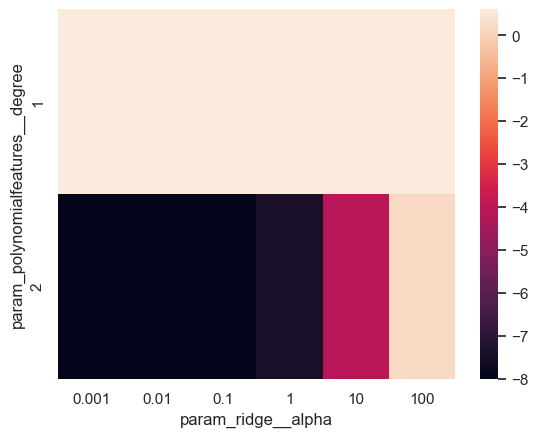

In [46]:
import seaborn as sns
sns.set()
sns.heatmap(df.loc[1:2])

* モデル自体を検証対象にすることも可能  
* irisのデータを使って、ランダムフォレストがいいのか、前処理ありのSVCがいいのか前処理なしのSVCがいいのか

In [47]:
from sklearn.ensemble import RandomForestClassifier

# 一度pipelineを適当に作る
pipe = Pipeline([
    ('preprocessing', StandardScaler()),
    ('classifier', SVC())
])
RandomForestClassifier()
param_grid = [
    {
        'classifier' : SVC(),
        'preprocessing' : [StandardScaler(),None],
        'classifier__gamma' : [.001, .01, .1, 1, 10, 100],
        'classifier__C' : [.001, .01, .1, 1, 10, 100],
    },
    {
        'classifier' : RandomForestClassifier(),
        'preprocessing' : None,
        'classifier__max_features' : [1, 2, 3],
    }
]